In [1]:
from IPython.display import HTML

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import os
import numpy as np

In [4]:
fname = os.path.join('..','results','rollingStats.mp4')

In [5]:
# the input file:
filename = 'opendap_hyrax_large_format_RS03ASHS-PN03B-06-CAMHDA301_2016_01_01_CAMHDA301-20160101T210000Z.mp4'

In [6]:
# the results directory
results_path = os.path.join(os.getcwd(),'..','results')

In [7]:
# the directory of the input file
video_path = os.path.join(os.getcwd(),'..','OOIVideos')

In [ ]:
video_encoded = open(fname, "rb").read().encode("base64")
video_tag = '<video width="800" height="800" controls alt="test" src="data:video/{0};base64,{1}">'.format("mp4", video_encoded)
HTML(data=video_tag)

#### Comparing rolling statistics of two sequences (two consecutive days).

In [8]:
# rolling_stats are pickled in store.pckl and store.pckl1

In [9]:
f= open(os.path.join('..','results','store.pckl'),'rb')

In [10]:
f1 = open(os.path.join('..','results','store.pckl1'),'rb')

In [11]:
import pickle

In [12]:
res = pickle.load(f)
res1 = pickle.load(f1)

In [13]:
f.close()
f1.close()

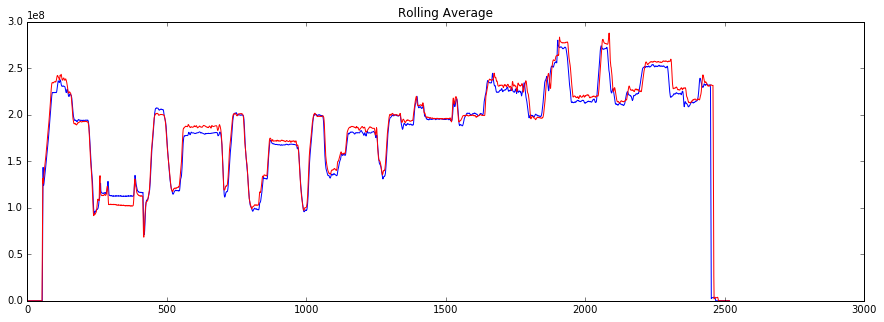

In [14]:
plt.figure(figsize = (15,5))
plt.plot(res[0])
plt.plot(res1[0],'r')
plt.title('Rolling Average')

Seems scenes start to get offset toward the end of the video.

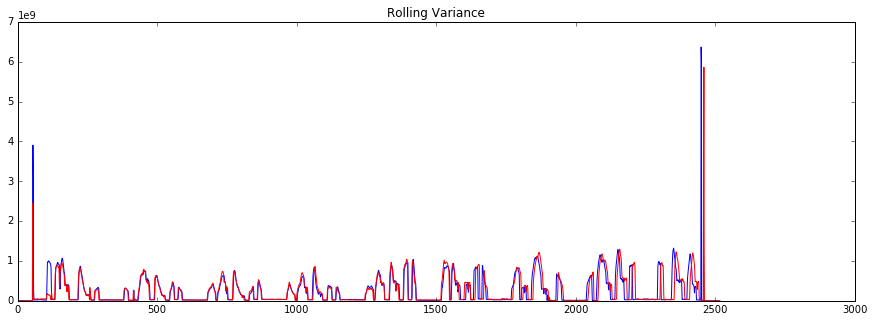

In [15]:
plt.figure(figsize = (15,5))
plt.plot(res[1])
plt.plot(res1[1],'r')
plt.title('Rolling Variance')

Seems frames start to get offse

##### Scene Extraction

We will try to extract scenes based on the rolling variance: we will look for areas where the variance is relatively small.

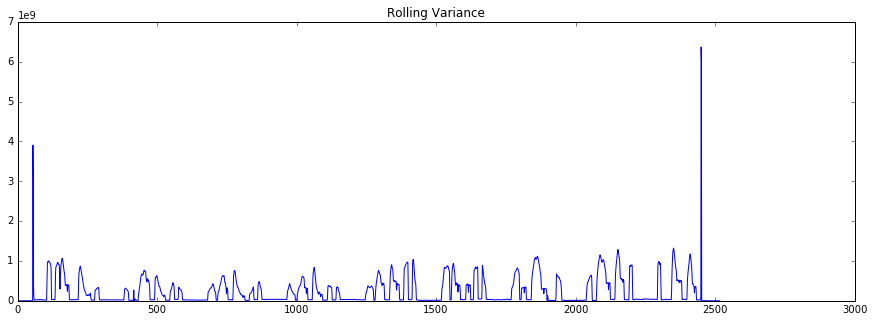

In [16]:
plt.figure(figsize = (15,5))
plt.plot(res[1])
plt.title('Rolling Variance')

In [17]:
# using 2*median as a threshold: the assumption is that the cutoff threshold is well above the median
thresh = 2*np.median(res[1])
binary = np.array(np.array(res[1])<thresh)

In [18]:
np.median(res[1])

36447343.444444448

In [19]:
# of time steps in scenes
sum(binary)

1397

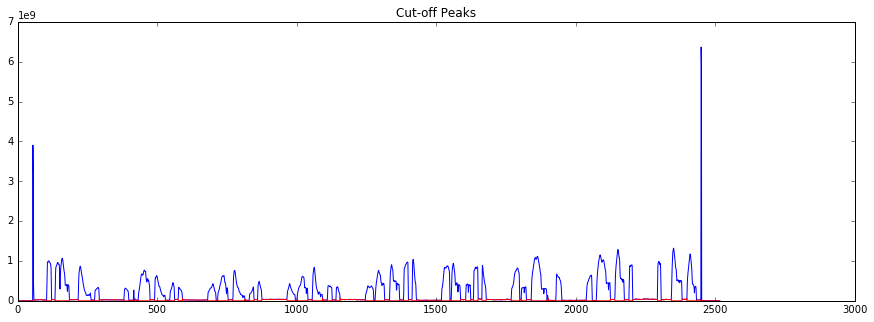

In [20]:
# removing chunks
plt.figure(figsize = (15,5))
plt.plot(np.array(res[1]))
plt.plot(np.array(res[1])*((np.array(res[1])<thresh)),'r')
plt.title('Cut-off Peaks')

In [21]:
def extractSceneBounds(rolling_var):
    """
        This function extracts the bounds of the scenes.
        
        
        Input: rolling_var
        Output: list of tuples: starting and ending time point for each scene
        
    """
    
    thresh = 2*np.median(rolling_var)
    binary = np.array(np.array(res[1])<thresh).astype('int')
    diff = binary[1:] - binary[:-1]
    upper_bound = np.where(diff == 1)[0]
    lower_bound = np.where(diff == -1)[0]
    
    return(zip(list(upper_bound),list(lower_bound)))
    
    

In [22]:
bounds = extractSceneBounds(res[1])

In [23]:
print(bounds)

[(58, 54), (121, 104), (185, 134), (263, 217), (292, 276), (398, 381), (417, 415), (474, 432), (529, 491), (562, 545), (590, 575), (711, 681), (754, 717), (814, 771), (847, 830), (875, 860), (995, 965), (1040, 1001), (1092, 1056), (1127, 1110), (1155, 1141), (1276, 1246), (1315, 1281), (1369, 1333), (1400, 1383), (1429, 1413), (1549, 1519), (1587, 1554), (1624, 1606), (1650, 1634), (1679, 1664), (1799, 1769), (1823, 1805), (1897, 1841), (1900, 1898), (1950, 1929), (2059, 2038), (2124, 2074), (2174, 2140), (2204, 2191), (2306, 2293), (2381, 2343), (2433, 2399), (2451, 2448)]


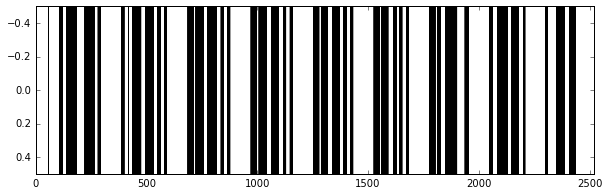

In [24]:
# white regions are scenes
plt.figure(figsize = (10,3))
plt.imshow(np.reshape(binary,(1,len(res[1]))),aspect = 'auto',cmap = 'gray')

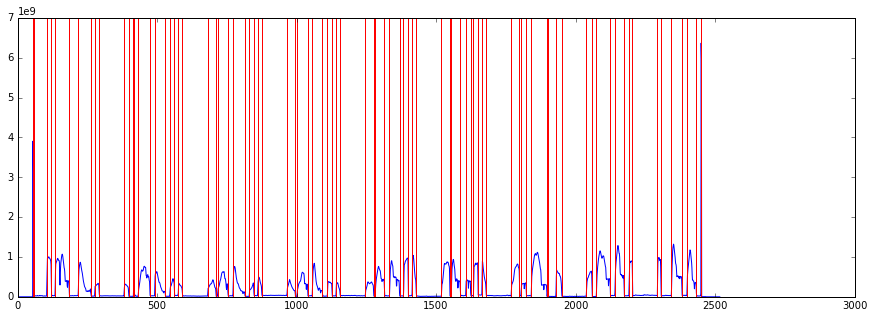

In [25]:
plt.figure(figsize = (15,5))
plt.plot(res[1])
for x in np.array(bounds).ravel():
    plt.axvline(x,color = 'r')

In [26]:
import imageio

In [27]:
# this function is really slow
def createSlicedVideo(binary, moviename,videoname, subsampleRate, speedup):
    
    
    vid_out = imageio.get_writer(videoname,fps = 30/subsampleRate*speedup)
    vid_in = imageio.get_reader(moviename,'ffmpeg')
    
    frame_idx = np.arange(0,len(vid_in),subsampleRate)
    
    fig = plt.figure()

    for i in range(len(binary)):
    #for i in range(60):
        
        print(i)
    
        
        im = vid_in.get_data(frame_idx[i])
        plt.subplot(211)
        plt.imshow(im*binary[i], aspect = 'equal')
        plt.axis('off')

    
        plt.subplot(212)
        plt.imshow(im*(1-binary[i]), aspect = 'equal')
        plt.axis('off')
    
    
        # convert the plot
        fig.canvas.draw()
        fig_data = np.fromstring(fig.canvas.tostring_rgb(), dtype=np.uint8, sep='')
        fig_data = fig_data.reshape(fig.canvas.get_width_height()[::-1] + (3,))
        
        vid_out.append_data(fig_data.astype(np.dtype('uint8')))
    
    vid_in.close()
    vid_out.close()

In [28]:
# this version is faster
def createSlicedVideo(binary, moviename,videoname, subsampleRate, speedup):
    """
        createSlicedVideo(binary, moviename,videoname, subsampleRate, speedup)
        
        It creates a video which masks the motion with black frames
        
        Input: 
        -----
        
        binary: a binary array of length number of subsampled frames (1 - scene, 0 - motion)
        
        
    """
    
    
    vid_out = imageio.get_writer(videoname,fps = 30/subsampleRate*speedup)
    vid_in = imageio.get_reader(moviename,'ffmpeg')
    
    frame_idx = np.arange(0,len(vid_in),subsampleRate)
    
    fig = plt.figure()

    for i in range(len(binary)):
    #for i in range(60):
        
        print(i)
    
        
        im = vid_in.get_data(frame_idx[i])
        vid_out.append_data(im*binary[i])
    
    vid_in.close()
    vid_out.close()

In [29]:
# unselect to save video
# createSlicedVideo(binary,os.path.join(video_path,filename),os.path.join(results_path,'slicedVideo.mp4'),10,10)

In [30]:
# unselect to save video
# createSlicedVideo(1- binary,os.path.join(video_path,filename),os.path.join(results_path,'slicedVideo_motion.mp4'),10,10)

In [ ]:
video_encoded = open(os.path.join(results_path,'slicedVideo_static.mp4'), "rb").read().encode("base64")
video_tag = '<video width="320" height="320" controls alt="test" src="data:video/{0};base64,{1}">'.format("mp4", video_encoded)
HTML(data=video_tag)

In [ ]:
video_encoded = open(os.path.join(results_path,'slicedVideo_motion.mp4'), "rb").read().encode("base64")
video_tag = '<video width="320" height="320" controls alt="test" src="data:video/{0};base64,{1}">'.format("mp4", video_encoded)
HTML(data=video_tag)